In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
from itertools import combinations
import matplotlib.patches as mpatches

In [ ]:
mod_path = 'data/embeddings/raw/'


genes_dict = {}


subdirs = [d for d in os.listdir(mod_path) if os.path.isdir(os.path.join(mod_path, d))]

for subdir in subdirs:
    print(subdir)
    subdir_path = os.path.join(mod_path, subdir)
    txt_files = [f for f in os.listdir(subdir_path) if f.endswith('.txt')]
    
    if txt_files:
        txt_path = os.path.join(subdir_path, txt_files[0])
        with open(txt_path, 'r') as f:
            genes = set(line.strip() for line in f if line.strip())
            genes_dict[subdir] = genes

print('done')



GENE2VEC_UNIPROT_HUMAN
T5_UNIPROT_HUMAN
MUT2VEC_UNIPROT_HUMAN
AAC_UNIPROT_HUMAN
PFAM_UNIPROT_HUMAN
ALBERT_UNIPROT_HUMAN
APAAC_UNIPROT_HUMAN
BERT-BFD_UNIPROT_HUMAN
BERT-PFAM_UNIPROT_HUMAN
BLAST_UNIPROT_HUMAN
CPC-PROT_UNIPROT_HUMAN
ESMB1_UNIPROT_HUMAN
HMMER_UNIPROT_HUMAN
KSEP_UNIPROT_HUMAN
LEARNED-VEC_UNIPROT_HUMAN
PROTVEC_UNIPROT_HUMAN
SEQVEC_UNIPROT_HUMAN
TCGA-EMBEDDING_UNIPROT_HUMAN
UNIREP_UNIPROT_HUMAN
XLNET_UNIPROT_HUMAN
NODE2VEC_UNIPROT_HUMAN
ESM2_UNIPROT_HUMAN
GENEPT-ADA_UNIPROT_HUMAN
GENEPT-MODEL3_UNIPROT_HUMAN
GF-12L30M_UNIPROT_HUMAN
BIOCONCEPTVEC-CBOW_UNIPROT_HUMAN
BIOCONCEPTVEC-SKIP-GRAM_UNIPROT_HUMAN
BIOCONCEPTVEC-GLOVE_UNIPROT_HUMAN
SCGPT-PANCANCER_UNIPROT_HUMAN
SCGPT-HUMAN_UNIPROT_HUMAN
FROGS-ARCHS4_UNIPROT_HUMAN
BIOCONCEPTVEC-FASTTEXT_UNIPROT_HUMAN
MASHUP_UNIPROT_HUMAN
GF-12L95M_UNIPROT_HUMAN
GF-12L95MCANCER_UNIPROT_HUMAN
GF-20L95M_UNIPROT_HUMAN
GF-6L30M_UNIPROT_HUMAN
done


<Figure size 576x432 with 0 Axes>

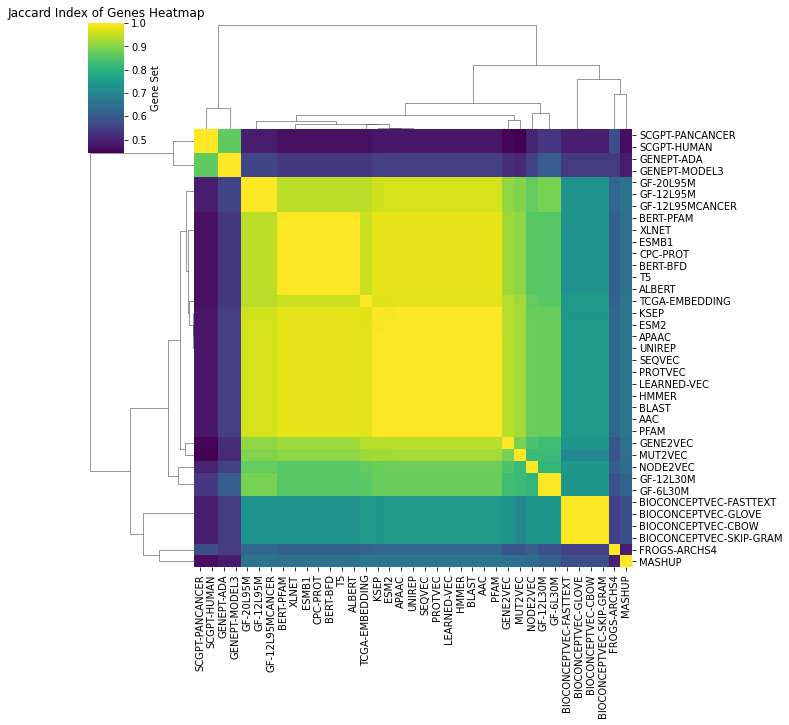

In [ ]:
genes_dict = {key: value for key, value in genes_dict.items()}
subdirs = list(genes_dict.keys())
jaccard_matrix = np.zeros((len(subdirs), len(subdirs)))

for i, key1 in enumerate(subdirs):
    for j, key2 in enumerate(subdirs):
        set1 = genes_dict[key1]
        set2 = genes_dict[key2]
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        jaccard_matrix[i, j] = intersection / union if union > 0 else 0

jaccard_df = pd.DataFrame(jaccard_matrix, index=subdirs, columns=subdirs)

plt.figure(figsize=(8, 6))
sns.clustermap(jaccard_df, annot=False, cmap="viridis", cbar=True, fmt=".2f")
plt.title("Jaccard Index of Genes Heatmap")
plt.xlabel("Gene Set")
plt.ylabel("Gene Set")
plt.show()


In [ ]:
common_genes = set.intersection(*genes_dict.values())

print(f"Number of common genes across all sets: {len(common_genes)}")

Number of common genes across all sets: 11355


In [ ]:

folder_path = 'data/embeddings/intersect/'


subfolders = [f.path for f in os.scandir(folder_path) if f.is_dir()]

embeddings = {}
gene_lists = {}

for subfolder in subfolders:
    print(subfolder)
    gene_txt_files = glob.glob(os.path.join(subfolder, '*.txt'))
    if not gene_txt_files:
        print(f"No txt file found in {subfolder}")
        continue
    gene_file = gene_txt_files[0]
    with open(gene_file, 'r') as f:
        genes = [line.strip() for line in f]
    gene_lists[subfolder] = genes

    csv_files = glob.glob(os.path.join(subfolder, '*.csv'))
    if not csv_files:
        print(f"No csv file found in {subfolder}")
        continue
    csv_file = csv_files[0]
    embedding = pd.read_csv(csv_file, header=None)
    embeddings[subfolder] = embedding

master_gene_list = gene_lists[subfolders[0]]
all_genes = set(master_gene_list)
for subfolder in subfolders[1:]:
    if set(gene_lists[subfolder]) != all_genes:
        print(f"Gene lists differ in {subfolder}")

embeddings_aligned = {}
for subfolder in subfolders:
    genes = gene_lists[subfolder]
    embedding = embeddings[subfolder]
    embedding.index = genes
    embedding_aligned = embedding.reindex(master_gene_list)
    embeddings_aligned[subfolder] = embedding_aligned

print("step2")


gene_correlation_matrices = {}
for subfolder, embedding in embeddings_aligned.items():
    embedding_T = embedding.transpose()
    print(embedding_T.shape, end="")
    gene_corr = embedding_T.corr(method='pearson')
    gene_corr = gene_corr.fillna(0)
    print(gene_corr.shape)
    gene_correlation_matrices[subfolder] = gene_corr

print("step3")

def scale_correlation_vector(corr_vector):
    return (corr_vector + 1) / 2

n_genes = len(master_gene_list)
rows, cols = np.triu_indices(n_genes, k=1)

scaled_correlation_vectors = {}
for subfolder, gene_corr in gene_correlation_matrices.items():
    upper_tri_values = gene_corr.values[rows, cols]
    scaled_corr_vector = scale_correlation_vector(upper_tri_values)
    scaled_correlation_vectors[subfolder] = scaled_corr_vector

subfolder_names = list(scaled_correlation_vectors.keys())
n_embeddings = len(subfolder_names)
weighted_jaccard_matrix = np.zeros((n_embeddings, n_embeddings))

for i in range(n_embeddings):
    for j in range(i, n_embeddings):
        vec1 = scaled_correlation_vectors[subfolder_names[i]]
        vec2 = scaled_correlation_vectors[subfolder_names[j]]
        min_sum = np.sum(np.minimum(vec1, vec2))
        max_sum = np.sum(np.maximum(vec1, vec2))
        wj_sim = min_sum / max_sum if max_sum != 0 else 0
        weighted_jaccard_matrix[i, j] = wj_sim
        weighted_jaccard_matrix[j, i] = wj_sim  


wj_sim_df = pd.DataFrame(weighted_jaccard_matrix, index=subfolder_names, columns=subfolder_names)

wj_sim_df_fixed = wj_sim_df.loc[:, wj_sim_df.isnull().sum() <= 3]
wj_sim_df_fixed = wj_sim_df_fixed.loc[wj_sim_df_fixed.isnull().sum(axis=1) <= 3]
wj_sim_df_fixed

In [ ]:

def clean_subfolder_name(name, base_path='data/embeddings/intersect/', suffix=''):

    if name.startswith(base_path):
        name = name[len(base_path):]
    
    if name.endswith(suffix):
        name = name[:-len(suffix)]
    
    return name


wj_sim_df_clean = wj_sim_df_fixed.copy()

wj_sim_df_clean.index = wj_sim_df_clean.index.map(clean_subfolder_name)

wj_sim_df_clean.columns = wj_sim_df_clean.columns.map(clean_subfolder_name)



In [ ]:
meta_df = pd.read_csv('data/embed_meta.csv', index_col=0, encoding='utf-8')  
meta_df.index = meta_df.index.str.replace(r'\s+', '', regex=True)


row_categories = meta_df.loc[wj_sim_df_clean.index, 'Category']
col_algorithms = meta_df.loc[wj_sim_df_clean.columns, 'Method']

unique_cats = row_categories.unique()
unique_algs = col_algorithms.unique()

row_palette = sns.color_palette("hls", n_colors=len(unique_cats))
col_palette = sns.color_palette("husl", n_colors=len(unique_algs))

cat_color_dict = dict(zip(unique_cats, row_palette))
alg_color_dict = dict(zip(unique_algs, col_palette))

cat_color_dict = {'gene expression (bulk)': "#920015",
 'gene expression (single cell)': "#ef476f",
 'amino acid sequence': "#ffd166",
 'PPI': "#06d6a0",
 'biomedical literature': "#118ab2",
 'mutation profile, biomedical literature, PPI': "#073b4c"}
alg_color_dict = {
  "skip-gram/CBOW":"#e5ba52",
  "Transformer":"#fefab0",
  "MLP":"#cc9b7d",
  "non-ML":"#0030bf",
  "RNN":"#cc9b7d",
  "matrix factorization":"#6c5dd2"}
col_colors = col_algorithms.map(alg_color_dict)
row_colors = row_categories.map(cat_color_dict)


In [ ]:
g = sns.clustermap(
    wj_sim_df_clean,
    annot=False,
    cmap='magma',
    fmt=".4f",
    square=True,
    linewidths=0,
    cbar_kws={"shrink": 0.5},
    row_colors=row_colors,
    col_colors=col_colors,
    figsize=(20, 20)
)

g.fig.suptitle('Weighted Jaccard Similarity of Gene Correlations', fontsize=16)

plt.setp(g.ax_heatmap.get_xticklabels(), rotation=90, ha='right', fontsize=20)
plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0, fontsize=20)

row_patches = [mpatches.Patch(color=c, label=cat) for cat, c in cat_color_dict.items()]
col_patches = [mpatches.Patch(color=c, label=alg) for alg, c in alg_color_dict.items()]

row_legend = g.ax_heatmap.legend(
    handles=row_patches,
    bbox_to_anchor=(1.2, 1.25),
    loc='upper left',
    borderaxespad=0,
    title="Data Type"
)

g.ax_heatmap.add_artist(row_legend)

col_legend = g.ax_heatmap.legend(
    handles=col_patches,
    bbox_to_anchor=(1.1, 1.25),
    loc='upper right',
    borderaxespad=0,
    title="Algorithm"
)

plt.savefig("results/plots/summary_weighted_heatmap.pdf", format="pdf", bbox_inches="tight")


plt.show()
